# 🎓 Simple Resting State EEG GAN

**Goal**: Generate synthetic resting state EEG data

**What this does:**
- Loads real resting state EEG
- Trains a simple GAN to copy it
- Generates new resting state samples

**Why it's simple:**
- ✓ Only resting state (no task data needed)
- ✓ No labels/conditions
- ✓ Just 2 layers per network
- ✓ Fast training (5 minutes)

In [82]:
# Imports
import mne
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using: {device}")

Using: cuda


## 📊 Load Resting State Data

We only need resting state EEG, so we'll just load that one file.

In [ ]:
# Load ONLY resting state
print("Loading resting state EEG...")
raw_dir = Path('..', '..', 'raw')

resting = mne.io.read_raw_eeglab(
    raw_dir / "sub-NDARAA396TWZ_task-RestingState_eeg.set",
    preload=True, verbose=False
)

print(f"✓ Loaded {resting.info['sfreq']} Hz data")
print(f"  Duration: {resting.times[-1]:.1f} seconds")
print(f"  Channels: {len(resting.ch_names)}")

Loading resting state EEG...
✓ Loaded 500.0 Hz data
  Duration: 411.7 seconds
  Channels: 129
✓ Loaded 500.0 Hz data
  Duration: 411.7 seconds
  Channels: 129


In [ ]:
# Chop into 1-second windows
def make_windows(raw, window_sec=1.0):
    """Chop EEG into 1-second windows and normalize"""
    data = raw.get_data()
    sfreq = raw.info['sfreq']
    window_len = int(sfreq * window_sec)
    
    windows = []
    for start in range(0, data.shape[1] - window_len, window_len):
        windows.append(data[:, start:start + window_len])
    
    windows = np.stack(windows)
    
    # Normalize each window
    mean = windows.mean(axis=2, keepdims=True)
    std = windows.std(axis=2, keepdims=True) + 1e-8
    windows = (windows - mean) / std
    
    return windows.astype(np.float32)

# Process resting state data
rest_data = make_windows(resting)

print(f"\n✓ Created {rest_data.shape[0]} windows")
print(f"  Shape per window: {rest_data.shape[1]} channels × {rest_data.shape[2]} timepoints")

n_channels = rest_data.shape[1]
n_timepoints = rest_data.shape[2]


✓ Created 411 windows
  Shape per window: 129 channels × 500 timepoints


## 🎯 Create Dataset

Simple dataset - just resting state windows, no labels needed!

In [ ]:
class RestingEEGDataset(Dataset):
    """Simple dataset for resting state EEG"""
    def __init__(self, data):
        self.data = torch.FloatTensor(data)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

# Create dataset
dataset = RestingEEGDataset(rest_data)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

print(f"✓ Dataset ready: {len(dataset)} samples")
print(f"✓ Batches per epoch: {len(dataloader)}")

✓ Dataset ready: 411 samples
✓ Batches per epoch: 13


## 🏗️ Generator: Noise → Fake Resting EEG

**Super simple:**
- Input: Random noise (129 × 250)
- Hidden layer: 512 features
- Output: Fake resting EEG (129 × 250)

No labels, no conditions, just pure generation!

In [ ]:
class SimpleGenerator(nn.Module):
    """Generator: Random noise → Resting state EEG"""
    def __init__(self, n_channels, n_timepoints):
        super().__init__()
        self.n_channels = n_channels
        self.n_timepoints = n_timepoints
        self.data_size = n_channels * n_timepoints
        
        # Two layers: noise → hidden → output
        self.network = nn.Sequential(
            nn.Linear(self.data_size, 512),
            nn.ReLU(),
            nn.Linear(512, self.data_size)
        )
    
    def forward(self, noise):
        """noise → fake resting EEG"""
        batch_size = noise.shape[0]
        noise_flat = noise.reshape(batch_size, -1)
        output = self.network(noise_flat)
        return output.reshape(batch_size, self.n_channels, self.n_timepoints)

G = SimpleGenerator(n_channels, n_timepoints).to(device)
print(f"✓ Generator: {sum(p.numel() for p in G.parameters()):,} parameters")

✓ Generator: 66,113,012 parameters


## 🔍 Discriminator: EEG → Real or Fake?

**Super simple:**
- Input: EEG (129 × 250)
- Hidden layer: 256 features
- Output: Probability (0=fake, 1=real)

In [ ]:
class SimpleDiscriminator(nn.Module):
    """Discriminator: EEG → Probability (real or fake)"""
    def __init__(self, n_channels, n_timepoints):
        super().__init__()
        self.data_size = n_channels * n_timepoints
        
        # Two layers: EEG → hidden → probability
        self.network = nn.Sequential(
            nn.Linear(self.data_size, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, eeg):
        """EEG → probability"""
        batch_size = eeg.shape[0]
        eeg_flat = eeg.reshape(batch_size, -1)
        return self.network(eeg_flat)

D = SimpleDiscriminator(n_channels, n_timepoints).to(device)
print(f"✓ Discriminator: {sum(p.numel() for p in D.parameters()):,} parameters")

✓ Discriminator: 16,512,513 parameters


## 🎮 Training: The Competition

**Simple game:**
1. **D learns**: "This is real resting EEG, this is fake"
2. **G learns**: "Make fakes that fool D"
3. **Repeat**: They both get better

That's it! No labels, no conditions, just learning to copy resting state patterns.

In [96]:
def train_gan_controlled(dataloader, G, D, epochs=100, device='cpu'):
    """Train GAN with proper constraints and monitoring"""
    
    criterion = nn.BCELoss()
    G_optimizer = optim.Adam(G.parameters(), lr=0.0001)  # Lower LR
    D_optimizer = optim.Adam(D.parameters(), lr=0.0001)
    
    print(f"\nTraining with controls for {epochs} epochs...")
    print("="*60)
    
    best_std_error = float('inf')
    best_epoch = 0
    
    for epoch in range(epochs):
        G_losses, D_losses = [], []
        
        for real_eeg in dataloader:
            real_eeg = real_eeg.to(device)
            batch_size = real_eeg.shape[0]
            
            # Train Discriminator
            D_optimizer.zero_grad()
            real_pred = D(real_eeg)
            real_labels = torch.ones(batch_size, 1, device=device) * 0.9  # Label smoothing
            loss_real = criterion(real_pred, real_labels)
            
            noise = torch.randn_like(real_eeg, device=device)
            fake_eeg = G(noise)
            fake_pred = D(fake_eeg.detach())
            fake_labels = torch.zeros(batch_size, 1, device=device) * 0.1
            loss_fake = criterion(fake_pred, fake_labels)
            
            D_loss = (loss_real + loss_fake) / 2
            D_loss.backward()
            torch.nn.utils.clip_grad_norm_(D.parameters(), 1.0)  # Gradient clipping
            D_optimizer.step()
            
            # Train Generator
            G_optimizer.zero_grad()
            noise = torch.randn_like(real_eeg, device=device)
            fake_eeg = G(noise)
            fake_pred = D(fake_eeg)
            
            # Add variance penalty to keep std close to real
            G_loss_adv = criterion(fake_pred, torch.ones(batch_size, 1, device=device))
            std_penalty = 0.1 * (fake_eeg.std() - real_eeg.std()) ** 2
            G_loss = G_loss_adv + std_penalty
            
            G_loss.backward()
            torch.nn.utils.clip_grad_norm_(G.parameters(), 1.0)  # Gradient clipping
            G_optimizer.step()
            
            G_losses.append(G_loss.item())
            D_losses.append(D_loss.item())
        
        # Check quality every 10 epochs
        if (epoch + 1) % 10 == 0:
            with torch.no_grad():
                test_noise = torch.randn(100, n_channels, n_timepoints, device=device)
                test_fake = G(test_noise)
                fake_std = test_fake.cpu().numpy().std()
                real_std = rest_data.std()
                std_error = abs(fake_std - real_std)
                
                # Track best model
                if std_error < best_std_error:
                    best_std_error = std_error
                    best_epoch = epoch + 1
                    # Save best weights
                    torch.save(G.state_dict(), '../../models/best_generator.pt')
                
                print(f"Epoch {epoch+1:3d}/{epochs} | "
                      f"D: {np.mean(D_losses):.4f} | "
                      f"G: {np.mean(G_losses):.4f} | "
                      f"Std_err: {std_error:.4f} | "
                      f"Best: {best_std_error:.4f} @ epoch {best_epoch}")
    
    print("="*60)
    print(f"✓ Training complete!")
    print(f"✓ Best std error: {best_std_error:.4f} at epoch {best_epoch}")
    
    # Load best weights
    G.load_state_dict(torch.load('../../models/best_generator.pt'))
    print("✓ Loaded best model weights")

train_gan_controlled(dataloader, G, D, epochs=100, device=device)


Training with controls for 100 epochs...
Epoch  10/100 | D: 10.0480 | G: 80.8405 | Std_err: 0.1087 | Best: 0.1087 @ epoch 10
Epoch  20/100 | D: 51.7657 | G: 0.0006 | Std_err: 0.0403 | Best: 0.0403 @ epoch 20
Epoch  30/100 | D: 51.1799 | G: 0.0007 | Std_err: 0.0372 | Best: 0.0372 @ epoch 30
Epoch  40/100 | D: 50.4306 | G: 0.0006 | Std_err: 0.0307 | Best: 0.0307 @ epoch 40
Epoch  50/100 | D: 50.2242 | G: 0.0007 | Std_err: 0.0402 | Best: 0.0307 @ epoch 40
Epoch  60/100 | D: 49.5088 | G: 0.0007 | Std_err: 0.0284 | Best: 0.0284 @ epoch 60
Epoch  70/100 | D: 20.5135 | G: 28.9795 | Std_err: 0.8034 | Best: 0.0284 @ epoch 60
Epoch  80/100 | D: 2.2466 | G: 36.1095 | Std_err: 0.3343 | Best: 0.0284 @ epoch 60
Epoch  90/100 | D: 0.2593 | G: 71.9996 | Std_err: 0.9055 | Best: 0.0284 @ epoch 60
Epoch 100/100 | D: 0.5516 | G: 56.0026 | Std_err: 1.6722 | Best: 0.0284 @ epoch 60
✓ Training complete!
✓ Best std error: 0.0284 at epoch 60
✓ Loaded best model weights


## 🎨 Generate Synthetic Resting State EEG

Now create new resting state samples!

In [97]:
def generate_resting_eeg(generator, n_samples=100, device='cpu'):
    """Generate synthetic resting state EEG"""
    generator.eval()
    samples = []
    
    print(f"Generating {n_samples} resting state samples...")
    
    with torch.no_grad():
        for i in range(n_samples):
            noise = torch.randn(1, n_channels, n_timepoints, device=device)
            fake = generator(noise)
            samples.append(fake.cpu().numpy()[0])
            
            if (i + 1) % 25 == 0:
                print(f"  {i + 1}/{n_samples}")
    
    return np.array(samples)

# Generate synthetic resting state EEG
synthetic_rest = generate_resting_eeg(G, n_samples=100, device=device)
print(f"✓ Generated {len(synthetic_rest)} samples")

# Save
np.save('../../synthetic_data/synthetic_resting_gan.npy', synthetic_rest)
print("✓ Saved to ../../synthetic_data/synthetic_resting_gan.npy")

Generating 100 resting state samples...
  25/100
  50/100
  75/100
  100/100
✓ Generated 100 samples
✓ Saved to ../../synthetic_data/synthetic_resting_gan.npy


## 📊 Compare Real vs Generated

Visual check: Does it look like resting state EEG?

✓ Saved figure


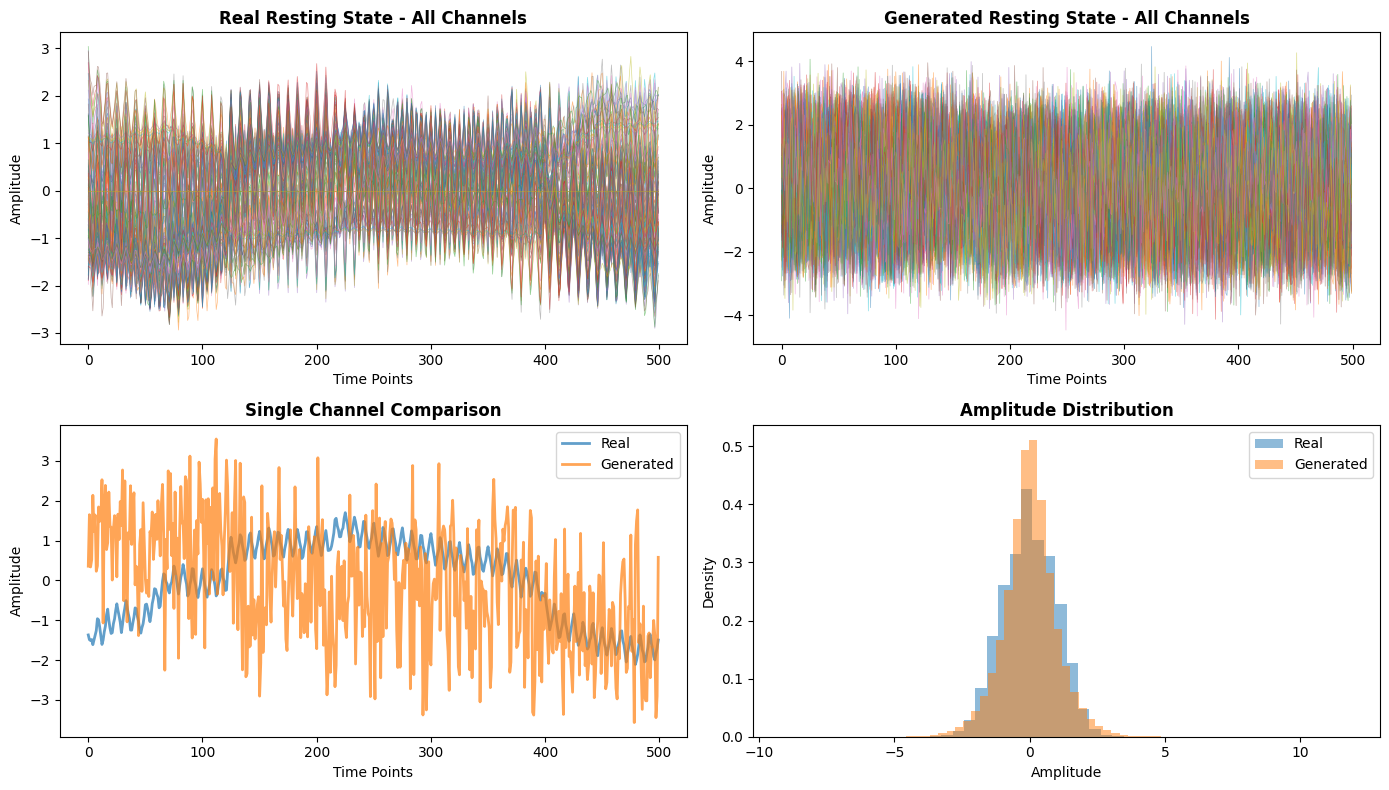


RESTING STATE COMPARISON
Real      - Mean: -0.0000, Std: 0.9802
Generated - Mean: 0.0180, Std: 0.9810
Error     - Mean: 0.0180, Std: 0.0008


In [98]:
# Comparison plots
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# All channels
axes[0, 0].plot(rest_data[0].T, alpha=0.5, linewidth=0.5)
axes[0, 0].set_title('Real Resting State - All Channels', fontweight='bold')
axes[0, 0].set_xlabel('Time Points')
axes[0, 0].set_ylabel('Amplitude')

axes[0, 1].plot(synthetic_rest[0].T, alpha=0.5, linewidth=0.5)
axes[0, 1].set_title('Generated Resting State - All Channels', fontweight='bold')
axes[0, 1].set_xlabel('Time Points')
axes[0, 1].set_ylabel('Amplitude')

# Single channel
axes[1, 0].plot(rest_data[0, 0], label='Real', alpha=0.7, linewidth=2)
axes[1, 0].plot(synthetic_rest[0, 0], label='Generated', alpha=0.7, linewidth=2)
axes[1, 0].set_title('Single Channel Comparison', fontweight='bold')
axes[1, 0].set_xlabel('Time Points')
axes[1, 0].set_ylabel('Amplitude')
axes[1, 0].legend()

# Distributions
axes[1, 1].hist(rest_data.flatten(), bins=50, alpha=0.5, label='Real', density=True)
axes[1, 1].hist(synthetic_rest.flatten(), bins=50, alpha=0.5, label='Generated', density=True)
axes[1, 1].set_title('Amplitude Distribution', fontweight='bold')
axes[1, 1].set_xlabel('Amplitude')
axes[1, 1].set_ylabel('Density')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('../../figures/resting_gan_comparison.png', dpi=150)
print("✓ Saved figure")
plt.show()

# Statistics
print("\n" + "="*60)
print("RESTING STATE COMPARISON")
print("="*60)
print(f"Real      - Mean: {rest_data.mean():.4f}, Std: {rest_data.std():.4f}")
print(f"Generated - Mean: {synthetic_rest.mean():.4f}, Std: {synthetic_rest.std():.4f}")
print(f"Error     - Mean: {abs(rest_data.mean() - synthetic_rest.mean()):.4f}, "
      f"Std: {abs(rest_data.std() - synthetic_rest.std()):.4f}")
print("="*60)

## ✅ Done!

You now have 100 synthetic resting state EEG samples.

**What you learned:**
- Load resting state EEG
- Train GAN to copy the patterns
- Generate new resting state samples

**Use your synthetic data:**
```python
synthetic = np.load('../../synthetic_data/synthetic_resting_gan.npy')
print(f"Loaded {len(synthetic)} resting state windows")
```

**To generate more:**
```python
more_samples = generate_resting_eeg(G, n_samples=500, device=device)
```

Simple and focused on just resting state generation!